In [5]:
run base_w2v_bow_svm.py

Reading english Data: 63386
Reading english Data: 63386
Merging the English and Japanes news dataframe...
Drop the null line...
False    63340
True         3
Name: en_article, dtype: int64


base_w2v_bow_svm.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_pairs_sample['word2vec_en'] = df_pairs_sample['en_article'].apply(doc2vec_en)
base_w2v_bow_svm.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_pairs_sample['word2vec_jp'] = df_pairs_sample['jp_article'].apply(doc2vec_jp)


0
1000
2000
3000
4000
0
1000
2000
3000
4000
C value = 1
classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       0.52      0.14      0.22      4000
        1.0       0.50      0.87      0.64      4000

avg / total       0.51      0.51      0.43      8000

classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       1.00      0.79      0.88      1000

avg / total       1.00      0.79      0.88      1000



Process Process-11:
Traceback (most recent call last):
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/M2015eliu/cas/2017.1.1~LiuSTM/base_w2v_bow_svm.py", line 90, in find_ranking_quick
    sys.stdout.write("Doc." + str(n * step + i) + ": " + str(rank) + "||")
NameError: global name 'sys' is not defined
Process Process-13:
Traceback (most recent call last):
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/M2015eliu/cas/2017.1.1~LiuSTM/base_w2v_bow_svm.py", line 90,

5.57616305351
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
dtype: float64
('TOP1', 0)
('TOP5', 0)
('TOP10', 0)


In [ ]:
# coding: utf-8

"""
created on 2017/05/11
@author: liuenda
"""

import numpy as np
import pandas as pd

from sklearn import cross_validation
from sklearn.metrics import classification_report
from gensim import corpora, models, similarities
from sklearn import datasets
from sklearn import linear_model
from sklearn import svm
from gensim.models import word2vec
from sklearn import preprocessing
import random
import pickle
import time


model_name_en = "./data/model-en/W2Vmodle.bin"
model_name_jp = "./data/model-jp/W2Vmodle.bin"

model_en = word2vec.Word2Vec.load(model_name_en)
model_jp = word2vec.Word2Vec.load(model_name_jp)


maxlen = 0 # Default: 0 -> infinite
epoch = 50
random.seed(1234)


"""
Find the ranking results with respect to real pairs
Defaulty, projection1 should be JP
Whiile, projection2 should be EN->JP
"""
def find_ranking(projection1, projection2, clf):
	sim_results = []
	rank_results = []

	# Iterate each of the ariticle from projection1 (999) as proj1
	# Calculate the simialrity of proj1 with all ariticles in projection2 (999)
	for i, proj1 in enumerate(projection1):
		print "Find answer for doc.", i
		proj1_tile = np.tile(proj1, (len(projection2),1))
		features_test = np.concatenate((proj1_tile, projection2), axis=1)
		sim = clf.predict_proba(features_test)[:,1]
		rank = pd.Series(sim).rank(ascending = False)[i]
		sim_results.append(sim)
		rank_results.append(rank)

	# sim_results contains 999*999 similairty matrix
	return sim_results, rank_results

"""
rank_results should be list of (999,)
"""
def find_top(rank_results, top):
	s = pd.Series(rank_results)
	n_top = (s <= top).sum()
	return n_top


def average_docment(document_embedding):
	return np.average(document_embedding, axis=0)

def sum_docment(document_embedding):
	return np.sum(document_embedding, axis=0)

def doc2feature(corpus, tfidf, dictionary, w2v):
    doc_features = []
    for index, doc_bof in enumerate(corpus):

        if index % 1000 == 0:
            print(index)

        doc_tfidf = tfidf[doc_bof]

        doc_feature = np.zeros((200,))

        for (token_id, token_tfidf) in doc_tfidf:
            token = dictionary.get(token_id, "[unknown-id]").encode("utf-8")
            # if token in w2v:
            if True:
                token_w2v = w2v[token]
            else:
                print("No word:", token)
                continue
            doc_feature += token_w2v * token_tfidf

        average = True
        if average:
            doc_feature = np.true_divide(doc_feature, len(doc_tfidf))
        doc_features.append(doc_feature)

    return doc_features

def doc2vec_en(doc):
	r = [model_en[token] for token in doc.split()]
	return r

def doc2vec_jp(doc):
	r = [model_jp[token] for token in doc.split()]
	return r


def prepare_train(dir_en, dir_jp):

	df_en_mapping = pd.read_csv(dir_en)
	df_jp_mapping = pd.read_csv(dir_jp)

	print "Reading english Data:", len(df_en_mapping)
	print "Reading english Data:", len(df_jp_mapping)

	sample_size = len(df_en_mapping)

	assert len(df_en_mapping) == len(df_jp_mapping)

	# Convert mapping to list type and then concat to the a list
	print "Merging the English and Japanes news dataframe..."
	df_train_1 = pd.concat([df_en_mapping, df_jp_mapping], axis = 1)
	df_train_1['similarity'] = pd.Series(np.ones(sample_size,)*5)
	df_train_1['dis_similarity'] = pd.Series(np.ones(sample_size,)*1)

	# Remove null line
	print "Drop the null line..."
	# df_train_1 = df_train_1.dropna(subset=['en_article'])
	df_train_1 = df_train_1[df_train_1['en_article'] != '<NULL>']

	# Expand the training data
	en_article_wrong = df_train_1.en_article.iloc[random.sample(xrange(len(df_train_1)),len(df_train_1))]
	en_article_wrong.index = df_train_1.index
	print (en_article_wrong == df_train_1.en_article).value_counts()
	df_train_1['en_article_wrong'] = en_article_wrong

	# Convert dateframe to list
	train_1 = df_train_1[['en_article','jp_article','similarity']].values.tolist()
	train_2 = df_train_1[['en_article_wrong','jp_article','dis_similarity']].values.tolist()

	return train_1, train_2, df_train_1

if __name__ == "__main__":


	input = 2
	k = 10

	# --- Prepare and Loading the training data --- #

	if input == 1:
		# Prepare For the training data
		sample_size = "_1000"
		dir_en = "./data/mapping/en_mapped_"+str(k) + sample_size + ".csv"
		dir_jp = "./data/mapping/jp_mapped_" + str(k) + sample_size + ".csv"

		# Prepare For the test data
		sample_size = "_1k2k"
		dir_en_test = "./data/mapping/en_mapped_"+str(k) + sample_size + ".csv"
		dir_jp_test = "./data/mapping/jp_mapped_" + str(k) + sample_size + ".csv"

		train_1, train_2, df_train_1 = 	prepare_train(dir_en, dir_jp)
		test_1, test_2, df_test_1 = prepare_train(dir_en_test, dir_jp_test)

	if input == 2:
		# split_line = 5000
		# end_line = 6000
		# Prepare For the training data
		dir_en = "./data/news/en_news.csv"
		dir_jp = "./data/news/jp_news.csv"

		pairs_correct, pairs_wrong, df_pairs = prepare_train(dir_en, dir_jp)
		train_1 = pairs_correct[0:2000] + pairs_correct[3000:5000]
		test_1 = pairs_correct[2000:3000]

		train_2 = pairs_wrong[0:2000] + pairs_wrong[3000:5000]
	# test_2 = pairs_wrong[split_line:end_line]


	# Expand the training data
	train = train_1 + train_2


	# --- Apply the word2vec model to the data sets --- #

	model_name_en = "./data/model-en/W2Vmodle.bin"
	model_name_jp = "./data/model-jp/W2Vmodle.bin"

	df_pairs_sample = df_pairs.iloc[0:5000]

	df_pairs_sample['word2vec_en'] = df_pairs_sample['en_article'].apply(doc2vec_en)
	df_pairs_sample['word2vec_jp'] = df_pairs_sample['jp_article'].apply(doc2vec_jp)


	# Feature 1: TF-IDF + Average word2vec

	# --- Find tf-idf * word2vec features --- #

    #  For English text:
    # texts_en = [doc.split() for doc in list(df_pairs_sample["en_article"])]
	texts_en = [doc.split() for doc in list(df_pairs["en_article"])]
	dictionary_en = corpora.Dictionary(texts_en)
	corpus_en = [dictionary_en.doc2bow(text) for text in texts_en]
	tfidf_en = models.TfidfModel(corpus_en)

	#  For Japanese text:
	# texts_jp = [doc.split() for doc in list(df_pairs_sample["jp_article"])]
	texts_jp = [doc.split() for doc in list(df_pairs["jp_article"])]
	dictionary_jp = corpora.Dictionary(texts_jp)
	corpus_jp = [dictionary_jp.doc2bow(text) for text in texts_jp]
	tfidf_jp = models.TfidfModel(corpus_jp)

	features_en = doc2feature(corpus_en[:5000], tfidf_en, dictionary_en, model_en)
	features_jp = doc2feature(corpus_jp[:5000], tfidf_jp, dictionary_jp, model_jp)

	# --- When do not apply the tfidf re-weighting --- #
	flag_NO_tfidf = False
	if flag_NO_tfidf:

		df_pairs_sample["sum_vector_en"] = df_pairs_sample['word2vec_en'].apply(sum_docment)
		df_pairs_sample["sum_vector_jp"] = df_pairs_sample['word2vec_jp'].apply(sum_docment)
		df_pairs_sample["average_vector_en"] = df_pairs_sample['word2vec_en'].apply(average_docment)
		df_pairs_sample["average_vector_jp"] = df_pairs_sample['word2vec_jp'].apply(average_docment)

		features_en = list(df_pairs_sample["average_vector_en"])
		features_jp = list(df_pairs_sample["average_vector_jp"])


	features_merge = np.concatenate((features_en,features_jp), axis = 1)

	# --- Expanding the training data (dissimilar paris)
	features_en_wrong = np.array(features_en)
	np.random.shuffle((features_en_wrong))
	c = np.all(features_en_wrong == features_en, axis=1)
	print "C value =", c.sum() # check the duplicated amount

	features_merge_wrong = np.concatenate((features_en_wrong,features_jp), axis = 1)

	# --- Prepare the final training and test data --- #

	X = np.concatenate((features_merge, features_merge_wrong), axis = 0)
	y = np.concatenate((np.ones(len(features_merge)), np.zeros(len(features_en_wrong))), axis = 0)

	# --- Split into test data and training data --- #

	X_train1, X_test, X_train2, X_train3_wrong, X_o = np.split(X, [2000, 3000, 5000, 9000])
	y_train1, y_test, y_train2, y_train3_wrong, Y_o = np.split(y, [2000, 3000, 9000, 9000])

	X_train = np.concatenate((X_train1, X_train2, X_train3_wrong), axis = 0)
	y_train = np.concatenate((y_train1, y_train2, y_train3_wrong), axis = 0)
	X_train_correct = np.concatenate((X_train1, X_train2), axis = 0)
	y_train_correct = np.concatenate((y_train1, y_train2), axis = 0)

	# --- SVM Training --- #

	clf = svm.SVC(kernel="rbf", gamma=0.001, C=100, probability=True)

	# 在使用
	standerlization = 0
	if standerlization == 1:
		scaler = preprocessing.StandardScaler().fit(X_train)
		X_scaled = scaler.transform(X_train)
		X_test_scaled = scaler.transform(X_test)
		clf.fit(X_scaled, y_train)

		y_test_predict = clf.predict(X_test_scaled)
		y_train_predict = clf.predict(X_scaled)

	if standerlization == 2:
		min_max_scaler = preprocessing.MinMaxScaler()
		X_scaled = min_max_scaler.fit_transform(X_train)
		X_test_scaled = min_max_scaler.transform(X_test)
		clf.fit(X_scaled, y_train)

		y_test_predict = clf.predict(X_test_scaled)
		y_train_predict = clf.predict(X_scaled)
	else:
		clf.fit(X_train, y_train)
		# clf.score(X_train, y_train)
		# clf.score(X_test, y_test)
		y_test_predict = clf.predict(X_test)
		y_train_predict = clf.predict(X_train)



	print "classification report of TRAINING data:"
	print(classification_report(y_train, y_train_predict))

	print "classification report of TEST data:"
	print(classification_report(y_test, y_test_predict))




	# --- Prepare for a new independent evaluation balanced data --- #

	df_pairs_evaluate = df_pairs.iloc[55000:60000]

	df_pairs_evaluate['word2vec_en'] = df_pairs_evaluate['en_article'].apply(doc2vec_en)
	df_pairs_evaluate['word2vec_jp'] = df_pairs_evaluate['jp_article'].apply(doc2vec_jp)

	features_en_eva = doc2feature(corpus_en[60000:61000], tfidf_en, dictionary_en, model_en)
	features_jp_eva = doc2feature(corpus_jp[60000:61000], tfidf_jp, dictionary_jp, model_jp)

	features_merge_eva = np.concatenate((features_en_eva,features_jp_eva), axis = 1)

	features_en_wrong_eva =  features_en[:1000]
	# features_en_wrong_eva = np.array(features_en_eva)
	# np.random.shuffle((features_en_wrong_eva))
	# c = np.all(features_en_wrong_eva == features_en_eva, axis=1)
	# print "C value =", c.sum() # check the duplicated amount

	features_merge_wrong = np.concatenate((features_en_wrong_eva,features_jp_eva), axis = 1)

	X_eva = np.concatenate((features_merge_eva, features_merge_wrong), axis = 0)
	y_eva = np.concatenate((np.ones(len(features_merge_eva)), np.zeros(len(features_en_wrong_eva))), axis = 0)

	y_eva_predict = clf.predict(X_eva)

	print "classification report of TRAINING data:"
	print(classification_report(y_eva, y_eva_predict))


	# --- Evaluation for SVM --- #

	y_test_proba = clf.predict_proba(X_test)
	y_train_proba = clf.predict_proba(X_train)

	# sim_results_train, rank_results_train = find_ranking(projection1_train, projection2_train)
	sim_results_test, rank_results_test = find_ranking(X_test[:,:200] ,X_test[:,200:], clf)


	print pd.Series(rank_results_test).describe()


Reading english Data: 63386
Reading english Data: 63386
Merging the English and Japanes news dataframe...
Drop the null line...
False    63340
True         3
Name: en_article, dtype: int64


/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0
1000
2000
3000
4000
0
1000
2000
3000
4000
C value = 5
classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       0.44      0.02      0.04      4000
        1.0       0.50      0.97      0.66      4000

avg / total       0.47      0.50      0.35      8000

classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       1.00      0.96      0.98      1000

avg / total       1.00      0.96      0.98      1000



/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0
0
classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       0.38      0.02      0.04      1000
        1.0       0.50      0.97      0.66      1000

avg / total       0.44      0.49      0.35      2000

Find answer for doc. 0
Find answer for doc. 1
Find answer for doc. 2
Find answer for doc. 3
Find answer for doc. 4
Find answer for doc. 5
Find answer for doc. 6
Find answer for doc. 7
Find answer for doc. 8
Find answer for doc. 9
Find answer for doc. 10
Find answer for doc. 11
Find answer for doc. 12
Find answer for doc. 13
Find answer for doc. 14
Find answer for doc. 15
Find answer for doc. 16
Find answer for doc. 17
Find answer for doc. 18
Find answer for doc. 19
Find answer for doc. 20
Find answer for doc. 21


In [8]:
# coding: utf-8

"""
created on 2017/05/11
@author: liuenda
"""

import numpy as np
import pandas as pd

from sklearn import cross_validation
from sklearn.metrics import classification_report
from gensim import corpora, models, similarities
from sklearn import datasets
from sklearn import linear_model
from sklearn import svm
from gensim.models import word2vec

import random
import pickle
import time


model_name_en = "./data/model-en/W2Vmodle.bin"
model_name_jp = "./data/model-jp/W2Vmodle.bin"

model_en = word2vec.Word2Vec.load(model_name_en)
model_jp = word2vec.Word2Vec.load(model_name_jp)


maxlen = 0 # Default: 0 -> infinite
epoch = 50
random.seed(1234)


"""
Find the ranking results with respect to real pairs
Defaulty, projection1 should be JP
Whiile, projection2 should be EN->JP
"""
def find_ranking(projection1, projection2, clf):
	sim_results = []
	rank_results = []

	# Iterate each of the ariticle from projection1 (999) as proj1
	# Calculate the simialrity of proj1 with all ariticles in projection2 (999)
	for i, proj1 in enumerate(projection1):
		print "Find answer for doc.", i
		proj1_tile = np.tile(proj1, (len(projection2),1))
		features_test = np.concatenate((proj1_tile, projection2), axis=1)
		sim = clf.predict_proba(features_test)[:,1]
		rank = pd.Series(sim).rank(ascending = False)[i]
		sim_results.append(sim)
		rank_results.append(rank)

	# sim_results contains 999*999 similairty matrix
	return sim_results, rank_results

"""
rank_results should be list of (999,)
"""
def find_top(rank_results, top):
	s = pd.Series(rank_results)
	n_top = (s <= top).sum()
	return n_top


def doc2feature(corpus, tfidf, dictionary, w2v):
    doc_features = []
    for index, doc_bof in enumerate(corpus):

        if index % 1000 == 0:
            print(index)

        doc_tfidf = tfidf[doc_bof]

        doc_feature = np.zeros((200,))

        for (token_id, token_tfidf) in doc_tfidf:
            token = dictionary.get(token_id, "[unknown-id]").encode("utf-8")
            # if token in w2v:
            if True:
                token_w2v = w2v[token]
            else:
                print("No word:", token)
                continue
            doc_feature += token_w2v * token_tfidf
        doc_features.append(doc_feature)

    return doc_features

def doc2vec_en(doc):
	r = [model_en[token] for token in doc.split()]
	return r

def doc2vec_jp(doc):
	r = [model_jp[token] for token in doc.split()]
	return r


def prepare_train(dir_en, dir_jp):

	df_en_mapping = pd.read_csv(dir_en)
	df_jp_mapping = pd.read_csv(dir_jp)

	print "Reading english Data:", len(df_en_mapping)
	print "Reading english Data:", len(df_jp_mapping)

	sample_size = len(df_en_mapping)

	assert len(df_en_mapping) == len(df_jp_mapping)

	# Convert mapping to list type and then concat to the a list
	print "Merging the English and Japanes news dataframe..."
	df_train_1 = pd.concat([df_en_mapping, df_jp_mapping], axis = 1)
	df_train_1['similarity'] = pd.Series(np.ones(sample_size,)*5)
	df_train_1['dis_similarity'] = pd.Series(np.ones(sample_size,)*1)

	# Remove null line
	print "Drop the null line..."
	# df_train_1 = df_train_1.dropna(subset=['en_article'])
	df_train_1 = df_train_1[df_train_1['en_article'] != '<NULL>']

	# Expand the training data
	en_article_wrong = df_train_1.en_article.iloc[random.sample(xrange(len(df_train_1)),len(df_train_1))]
	en_article_wrong.index = df_train_1.index
	print (en_article_wrong == df_train_1.en_article).value_counts()
	df_train_1['en_article_wrong'] = en_article_wrong

	# Convert dateframe to list
	train_1 = df_train_1[['en_article','jp_article','similarity']].values.tolist()
	train_2 = df_train_1[['en_article_wrong','jp_article','dis_similarity']].values.tolist()

	return train_1, train_2, df_train_1

if __name__ == "__main__":


	input = 2
	k = 10

	# --- Prepare and Loading the training data --- #

	if input == 1:
		# Prepare For the training data
		sample_size = "_1000"
		dir_en = "./data/mapping/en_mapped_"+str(k) + sample_size + ".csv"
		dir_jp = "./data/mapping/jp_mapped_" + str(k) + sample_size + ".csv"

		# Prepare For the test data
		sample_size = "_1k2k"
		dir_en_test = "./data/mapping/en_mapped_"+str(k) + sample_size + ".csv"
		dir_jp_test = "./data/mapping/jp_mapped_" + str(k) + sample_size + ".csv"

		train_1, train_2, df_train_1 = 	prepare_train(dir_en, dir_jp)
		test_1, test_2, df_test_1 = prepare_train(dir_en_test, dir_jp_test)

	if input == 2:
		# split_line = 5000
		# end_line = 6000
		# Prepare For the training data
		dir_en = "./data/news/en_news.csv"
		dir_jp = "./data/news/jp_news.csv"

		pairs_correct, pairs_wrong, df_pairs = prepare_train(dir_en, dir_jp)
		train_1 = pairs_correct[0:2000] + pairs_correct[3000:5000]
		test_1 = pairs_correct[2000:3000]

		train_2 = pairs_wrong[0:2000] + pairs_wrong[3000:5000]
	# test_2 = pairs_wrong[split_line:end_line]


	# Expand the training data
	train = train_1 + train_2


	# --- Apply the word2vec model to the data sets --- #

	model_name_en = "./data/model-en/W2Vmodle.bin"
	model_name_jp = "./data/model-jp/W2Vmodle.bin"

	df_pairs_sample = df_pairs.iloc[0:5000]

	df_pairs_sample['word2vec_en'] = df_pairs_sample['en_article'].apply(doc2vec_en)
	df_pairs_sample['word2vec_jp'] = df_pairs_sample['jp_article'].apply(doc2vec_jp)


	# Feature 1: TF-IDF + Average word2vec

	# --- Find tf-idf * word2vec features --- #

    #  For English text:
	texts_en = [doc.split() for doc in list(df_pairs_sample["en_article"])]
	dictionary_en = corpora.Dictionary(texts_en)
	corpus_en = [dictionary_en.doc2bow(text) for text in texts_en]
	tfidf_en = models.TfidfModel(corpus_en)

	#  For Japanese text:
	texts_jp = [doc.split() for doc in list(df_pairs_sample["jp_article"])]
	dictionary_jp = corpora.Dictionary(texts_jp)
	corpus_jp = [dictionary_jp.doc2bow(text) for text in texts_jp]
	tfidf_jp = models.TfidfModel(corpus_jp)

	features_en = doc2feature(corpus_en, tfidf_en, dictionary_en, model_en)
	features_jp = doc2feature(corpus_jp, tfidf_jp, dictionary_jp, model_jp)

	features_merge = np.concatenate((features_en,features_jp), axis = 1)

	# --- Expanding the training data (dissimilar paris)
	features_en_wrong = np.array(features_en)
	np.random.shuffle((features_en_wrong))
	c = np.all(features_en_wrong == features_en, axis=1)
	print "C value =", c.sum() # check the duplicated amount

	features_merge_wrong = np.concatenate((features_en_wrong,features_jp), axis = 1)

	# --- Prepare the final training and test data --- #

	X = np.concatenate((features_merge, features_merge_wrong), axis = 0)
	y = np.concatenate((np.ones(len(features_merge)), np.zeros(len(features_en_wrong))), axis = 0)

	# --- Split into test data and training data --- #

	X_train1, X_test, X_train2, X_train3_wrong = np.split(X, [2000, 3000, 5000])
	y_train1, y_test, y_train2, y_train3_wrong = np.split(y, [2000, 3000, 5000])

	X_train = np.concatenate((X_train1, X_train2, X_train3_wrong), axis = 0)
	y_train = np.concatenate((y_train1, y_train2, y_train3_wrong), axis = 0)
	X_train_correct = np.concatenate((X_train1, X_train2), axis = 0)
	y_train_correct = np.concatenate((y_train1, y_train2), axis = 0)

	# --- SVM Training --- #

	clf = svm.SVC(kernel="rbf", gamma=0.001, C=100, probability=True)
	clf.fit(X_train, y_train)
	# clf.score(X_train, y_train)
	# clf.score(X_test, y_test)

	y_test_predict = clf.predict(X_test)
	y_train_predict = clf.predict(X_train)

	print "classification report of TRAINING data:"
	print(classification_report(y_train_predict, y_train))

	print "classification report of TEST data:"
	print(classification_report(y_test_predict, y_test))

	y_test_proba = clf.predict_proba(X_test)
	y_train_proba = clf.predict_proba(X_train)

	# --- Evaluation for SVM --- #

	# sim_results_train, rank_results_train = find_ranking(projection1_train, projection2_train)
	sim_results_test, rank_results_test = find_ranking(X_test[:,:200] ,X_test[:,200:], clf)

Reading english Data: 63386
Reading english Data: 63386
Merging the English and Japanes news dataframe...
Drop the null line...
False    63340
True         3
Name: en_article, dtype: int64


/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:184: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/ipykernel/__main__.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0
1000
2000
3000
4000
0
1000
2000
3000
4000
C value = 5
classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       0.96      1.00      0.98      4819
        1.0       1.00      0.96      0.98      4181

avg / total       0.98      0.98      0.98      9000

classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00        57
        1.0       0.94      1.00      0.97       943

avg / total       0.89      0.94      0.92      1000



/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Find answer for doc. 0
Find answer for doc. 1
Find answer for doc. 2
Find answer for doc. 3
Find answer for doc. 4
Find answer for doc. 5
Find answer for doc. 6
Find answer for doc. 7
Find answer for doc. 8
Find answer for doc. 9
Find answer for doc. 10
Find answer for doc. 11
Find answer for doc. 12
Find answer for doc. 13
Find answer for doc. 14
Find answer for doc. 15
Find answer for doc. 16
Find answer for doc. 17
Find answer for doc. 18
Find answer for doc. 19
Find answer for doc. 20
Find answer for doc. 21
Find answer for doc. 22
Find answer for doc. 23
Find answer for doc. 24
Find answer for doc. 25
Find answer for doc. 26
Find answer for doc. 27
Find answer for doc. 28


KeyboardInterrupt: 

In [9]:
run base_w2v_bow_svm.py

Reading english Data: 63386
Reading english Data: 63386
Merging the English and Japanes news dataframe...
Drop the null line...
False    63340
True         3
Name: en_article, dtype: int64


base_w2v_bow_svm.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_pairs_sample['word2vec_jp'] = df_pairs_sample['jp_article'].apply(doc2vec_jp)
base_w2v_bow_svm.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0
1000
2000
3000
4000
0
1000
2000
3000
4000
C value = 3
Usinge the None
classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       1.00      0.96      0.98      4000
        1.0       0.96      1.00      0.98      4000

avg / total       0.98      0.98      0.98      8000

classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         0
        1.0       1.00      0.93      0.97      1000

avg / total       1.00      0.93      0.97      1000

Doc.100: 5.0||Doc.400: 4.0||Doc.200: 52.0||Doc.500: 1.5||Doc.300: 2.0||Doc.0: 3.0||Doc.600: 20.5||Doc.700: 58.5||Doc.800: 6.5||Doc.900: 1.5||Doc.101: 8.0||Doc.501: 3.5||Doc.401: 14.0||Doc.301: 6.5||Doc.801: 77.5||Doc.201: 11.0||Doc.601: 10.0||Doc.701: 8.0||Doc.1: 2.0||Doc.901: 3.5||Doc.502: 1.0||Doc.102: 4.0||Doc.402: 2.0||Doc.302: 7.0||Doc.802: 65.5||Doc.202: 10.0||Doc.602: 1.0||Doc.902: 13.0||Doc.702: 6.0||Doc.2: 1.0

In [10]:
run base_w2v_bow_svm.py

Reading english Data: 63386
Reading english Data: 63386
Merging the English and Japanes news dataframe...
Drop the null line...
False    63340
True         3
Name: en_article, dtype: int64


base_w2v_bow_svm.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_pairs_sample['word2vec_jp'] = df_pairs_sample['jp_article'].apply(doc2vec_jp)
base_w2v_bow_svm.py:259: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0
1000
2000
3000
4000
0
1000
2000
3000
4000
C value = 4
Usinge the None
classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       1.00      0.50      0.67      7937
        1.0       0.01      0.73      0.02        63

avg / total       0.99      0.50      0.66      8000

classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00       995
        1.0       0.01      1.00      0.01         5

avg / total       0.00      0.01      0.00      1000

Doc.0: 500.5||Doc.600: 500.5||Doc.900: 500.5||Doc.400: 500.5||Doc.800: 500.5||Doc.700: 500.5||Doc.100: 500.5||Doc.200: 500.5||Doc.300: 500.5||Doc.500: 500.5||Doc.1: 500.5||Doc.601: 500.5||Doc.901: 500.5||Doc.701: 500.5||Doc.401: 500.5||Doc.801: 500.5||Doc.101: 500.5||Doc.501: 500.5||Doc.201: 500.5||Doc.301: 500.5||Doc.602: 500.5||Doc.402: 500.5||Doc.702: 500.5||Doc.2: 500.5||Doc.902: 500.5||Doc.802: 500.5||Doc.502: 500

Process Process-34:
Traceback (most recent call last):
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/M2015eliu/cas/2017.1.1~LiuSTM/base_w2v_bow_svm.py", line 86, in find_ranking_quick
    sim = clf.predict_proba(features_test)[:, 1]
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/sklearn/svm/base.py", line 625, in _predict_proba
    return pred_proba(X)
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/sklearn/svm/base.py", line 673, in _dense_predict_proba
    cache_size=self.cache_size, coef0=self.coef0, gamma=self._gamma)
KeyboardInterrupt


KeyboardInterrupt: 

Process Process-37:
Traceback (most recent call last):
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "/home/M2015eliu/cas/2017.1.1~LiuSTM/base_w2v_bow_svm.py", line 86, in find_ranking_quick
    sim = clf.predict_proba(features_test)[:, 1]
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/sklearn/svm/base.py", line 625, in _predict_proba
    return pred_proba(X)
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/lib/python2.7/site-packages/sklearn/svm/base.py", line 673, in _dense_predict_proba
    cache_size=self.cache_size, coef0=self.coef0, gamma=self._gamma)
KeyboardInterrupt
Process Process-32:
Traceback (most recent call last):
  File "/home/M2015eliu/.pyenv/versions/anaconda2-4.1.1/li

In [13]:
run base_w2v_bow_svm.py

('average=', True)
Reading english Data: 63386
Reading english Data: 63386
Merging the English and Japanes news dataframe...
Drop the null line...
False    63340
True         3
Name: en_article, dtype: int64


base_w2v_bow_svm.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_pairs_sample['word2vec_en'] = df_pairs_sample['en_article'].apply(doc2vec_en)
base_w2v_bow_svm.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_pairs_sample['word2vec_jp'] = df_pairs_sample['jp_article'].apply(doc2vec_jp)


0
1000
2000
3000
4000
0
1000
2000
3000
4000
C value = 3
Usinge the None
classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       0.53      0.14      0.22      4000
        1.0       0.50      0.88      0.64      4000

avg / total       0.52      0.51      0.43      8000

classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.23      0.06      0.09      1000
        1.0       0.46      0.81      0.59      1000

avg / total       0.35      0.43      0.34      2000

Doc.200: 500.5||Doc.300: 500.0||Doc.100: 500.5||Doc.400: 500.5||Doc.0: 500.0||Doc.800: 500.5||Doc.700: 500.5||Doc.500: 500.5||Doc.600: 500.5||Doc.900: 500.5||Doc.101: 500.5||Doc.201: 500.0||Doc.301: 500.5||Doc.801: 500.5||Doc.701: 500.5||Doc.401: 500.5||Doc.501: 500.0||Doc.1: 500.5||Doc.601: 500.5||Doc.901: 500.5||Doc.202: 500.5||Doc.302: 500.5||Doc.802: 500.5||Doc.102: 500.0||Doc.702: 500.0||Doc.502: 500.5||Doc.402: 5

In [14]:
run base_w2v_bow_svm.py

('average=', False)
Reading english Data: 63386
Reading english Data: 63386
Merging the English and Japanes news dataframe...
Drop the null line...
False    63340
True         3
Name: en_article, dtype: int64


base_w2v_bow_svm.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_pairs_sample['word2vec_en'] = df_pairs_sample['en_article'].apply(doc2vec_en)
base_w2v_bow_svm.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_pairs_sample['word2vec_jp'] = df_pairs_sample['jp_article'].apply(doc2vec_jp)


0
1000
2000
3000
4000
0
1000
2000
3000
4000
C value = 1
Usinge the None
classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       1.00      0.96      0.98      4000
        1.0       0.96      1.00      0.98      4000

avg / total       0.98      0.98      0.98      8000

classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.95      0.87      0.91      1000
        1.0       0.88      0.96      0.92      1000

avg / total       0.92      0.91      0.91      2000

Doc.0: 6.0||Doc.100: 6.0||Doc.200: 37.0||Doc.300: 6.0||Doc.400: 1.0||Doc.500: 1.5||Doc.600: 13.5||Doc.700: 46.5||Doc.800: 5.5||Doc.900: 3.5||Doc.1: 4.0||Doc.401: 31.0||Doc.101: 7.0||Doc.201: 7.0||Doc.601: 2.0||Doc.701: 4.0||Doc.301: 6.5||Doc.501: 2.5||Doc.801: 55.5||Doc.901: 3.5||Doc.2: 1.0||Doc.402: 2.0||Doc.102: 3.0||Doc.602: 1.0||Doc.702: 4.0||Doc.202: 28.0||Doc.502: 2.0||Doc.302: 8.0||Doc.902: 2.0||Doc.802: 25.5||D

In [15]:
run base_w2v_bow_svm.py

('average=', False)
Reading english Data: 63386
Reading english Data: 63386
Merging the English and Japanes news dataframe...
Drop the null line...
False    63340
True         3
Name: en_article, dtype: int64


base_w2v_bow_svm.py:257: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_pairs_sample['word2vec_en'] = df_pairs_sample['en_article'].apply(doc2vec_en)
base_w2v_bow_svm.py:258: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_pairs_sample['word2vec_jp'] = df_pairs_sample['jp_article'].apply(doc2vec_jp)


0
1000
2000
3000
4000
0
1000
2000
3000
4000
C value = 3
Usinge the None
classification report of TRAINING data:
             precision    recall  f1-score   support

        0.0       1.00      0.96      0.98      4000
        1.0       0.96      1.00      0.98      4000

avg / total       0.98      0.98      0.98      8000

classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.95      0.88      0.91      1000
        1.0       0.89      0.95      0.92      1000

avg / total       0.92      0.92      0.92      2000

Doc.0: 5.0||Doc.200: 60.0||Doc.100: 8.0||Doc.300: 5.0||Doc.400: 3.0||Doc.600: 5.5||Doc.500: 1.5||Doc.700: 58.5||Doc.800: 8.5||Doc.900: 1.5||Doc.1: 3.0||Doc.201: 6.0||Doc.401: 13.0||Doc.101: 7.0||Doc.301: 2.5||Doc.501: 2.5||Doc.601: 9.0||Doc.701: 11.0||Doc.801: 11.5||Doc.2: 1.0||Doc.901: 1.5||Doc.102: 3.0||Doc.502: 2.0||Doc.402: 3.0||Doc.202: 35.0||Doc.302: 6.0||Doc.602: 6.0||Doc.702: 8.0||Doc.103: 1.0||Doc.503: 2.0||Do

In [27]:
	# ---- Independent test data ---- #
	print("Using the new test data to evaluate.......")
	df_pairs_evaluate = df_pairs.iloc[50000:55000:5]

	texts_en_new = [doc.split() for doc in list(df_pairs_evaluate["en_article"])]
	corpus_en_new = [dictionary_en.doc2bow(text) for text in texts_en_new]

	texts_jp_new = [doc.split() for doc in list(df_pairs_evaluate["jp_article"])]
	corpus_jp_new = [dictionary_jp.doc2bow(text) for text in texts_jp_new]

	features_en_new = doc2feature(corpus_en_new[:1000], tfidf_en, dictionary_en, model_en)
	features_jp_new = doc2feature(corpus_jp_new[:1000], tfidf_jp, dictionary_jp, model_jp)

	features_merge_1_new = np.concatenate((features_en_new, features_jp_new), axis=1)

	# X_test_scaled_new = scaler.transform(features_merge_new)
	X_test_scaled_1_new = features_merge_1_new
	# --- Expanding the training data (dissimilar paris)
	features_en_wrong_new = np.array(features_en_new)
	np.random.shuffle((features_en_wrong_new))
	c = np.all(features_en_wrong_new == features_en_new, axis=1)
	print "C value =", c.sum() # check the duplicated amount

	features_merge_wrong_new = np.concatenate((features_en_wrong_new,features_jp_new), axis = 1)

	# --- Prepare the final training and test data --- #
	X_test_scaled_new = np.concatenate((features_merge_1_new, features_merge_wrong_new), axis = 0)
	
	y_test_predict_new = clf.predict(X_test_scaled_new)
	print "classification report of TEST data:"
	print(classification_report(y_test, y_test_predict_new))


Using the new test data to evaluate.......
0
0
C value = 0
classification report of TEST data:
             precision    recall  f1-score   support

        0.0       0.93      0.91      0.92      1000
        1.0       0.91      0.93      0.92      1000

avg / total       0.92      0.92      0.92      2000



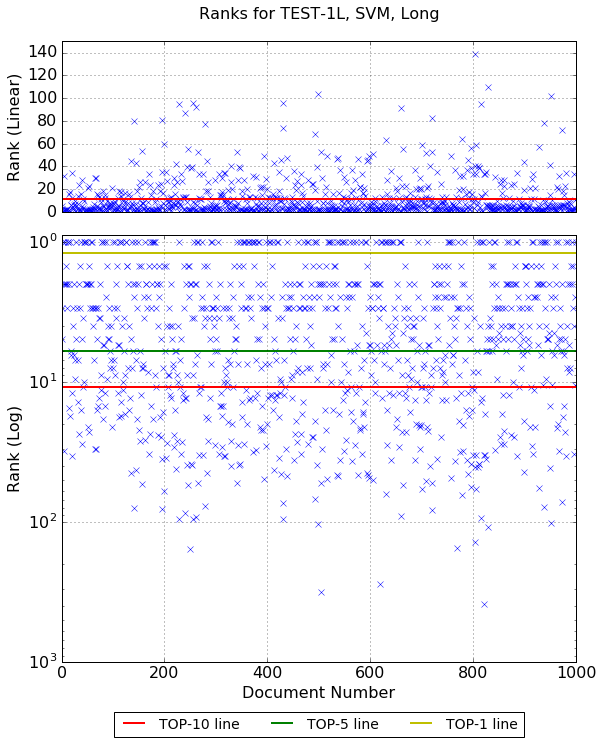

In [22]:
# %matplotlib inline
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(8.5, 10)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2.5]) 
ax1 = fig.add_subplot(gs[0])


plt.plot(rank_results_test,'bx')
ax1.set_title('Ranks for TEST-1L, SVM, Long\n', fontsize=16)
ax1.set_ylabel('Rank (Linear)', fontsize=16)
# ax1.set_ylim([100,0])
ax1.set_ylim([0,150])
ax1.plot([0, 1000], [11, 11], 'r-', lw=2, label = "TOP-10 line")
# ax.plot([0, 1000], [6, 6], 'g-', lw=2, label ="TOP-5 line")
# ax.plot([0, 1000], [1.2, 1.2], 'y:', lw=2, label = "TOP-1 line")
ax1.tick_params(axis='y', labelsize=16)
# plt.ylim([30,0.5])
ax1.grid(True)
# plt.show()
ax1.xaxis.set_ticklabels([])


# fig = plt.figure(figsize=(10, 17))
ax2 = fig.add_subplot(gs[1])
ax2.plot(rank_results_test,'bx')

ax2.set_xlabel('Document Number', fontsize=16)
ax2.set_ylabel('Rank (Log)', fontsize=16)
ax2.set_ylim([1000,0.9])
# plt.ylim([0.9,1000])
ax2.set_yscale('log')
ax2.grid()
# plt.ylim([30,0.5])
ax2.plot([0, 1000], [11, 11], 'r-', lw=2, label = "TOP-10 line")
ax2.plot([0, 1000], [6, 6], 'g-', lw=2, label ="TOP-5 line")
ax2.plot([0, 1000], [1.2, 1.2], 'y-', lw=2, label = "TOP-1 line")
lgd = plt.legend(loc='upper center', ncol=3, fontsize=14, bbox_to_anchor=(0.5, -0.1))
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
plt.tight_layout()
plt.savefig('long-svm-test1.pdf', format='pdf', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

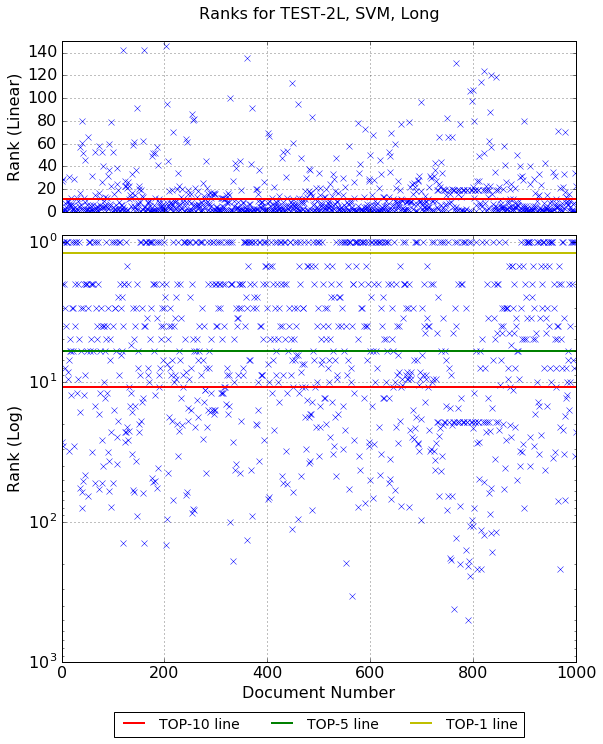

In [21]:
%matplotlib inline
from matplotlib import gridspec
import matplotlib.pyplot as plt
import matplotlib

fig = plt.figure(figsize=(8.5, 10)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[1, 2.5]) 
ax1 = fig.add_subplot(gs[0])


plt.plot(rank_results_test_new,'bx')
ax1.set_title('Ranks for TEST-2L, SVM, Long\n', fontsize=16)
ax1.set_ylabel('Rank (Linear)', fontsize=16)
# ax1.set_ylim([100,0])
ax1.set_ylim([0,150])
ax1.plot([0, 1000], [11, 11], 'r-', lw=2, label = "TOP-10 line")
# ax.plot([0, 1000], [6, 6], 'g-', lw=2, label ="TOP-5 line")
# ax.plot([0, 1000], [1.2, 1.2], 'y:', lw=2, label = "TOP-1 line")
ax1.tick_params(axis='y', labelsize=16)
# plt.ylim([30,0.5])
ax1.grid(True)
# plt.show()
ax1.xaxis.set_ticklabels([])


# fig = plt.figure(figsize=(10, 17))
ax2 = fig.add_subplot(gs[1])
ax2.plot(rank_results_test_new,'bx')

ax2.set_xlabel('Document Number', fontsize=16)
ax2.set_ylabel('Rank (Log)', fontsize=16)
ax2.set_ylim([1000,0.9])
# plt.ylim([0.9,1000])
ax2.set_yscale('log')
ax2.grid()
# plt.ylim([30,0.5])
ax2.plot([0, 1000], [11, 11], 'r-', lw=2, label = "TOP-10 line")
ax2.plot([0, 1000], [6, 6], 'g-', lw=2, label ="TOP-5 line")
ax2.plot([0, 1000], [1.2, 1.2], 'y-', lw=2, label = "TOP-1 line")
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
lgd = plt.legend(loc='upper center', ncol=3, fontsize=14, bbox_to_anchor=(0.5, -0.1))
plt.tight_layout()
plt.savefig('long-svm-test2.pdf', format='pdf', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()